In [2]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import warnings

warnings.filterwarnings('ignore')

# Import the data

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.utils import to_categorical

from utils.dataset import get_train_test_data

# get the train and test data in rgb format
(train_data, train_labels), (test_data, test_labels) = get_train_test_data(rgb=True, verbose=True)
# Turn the labels into one-bit-hot-encoding
train_labels_cat, test_labels_cat = to_categorical(train_labels), to_categorical(test_labels)
# convert the data to grayscale
train_data_gs, test_data_gs = (
    tf.image.rgb_to_grayscale(train_data).numpy(),
    tf.image.rgb_to_grayscale(test_data).numpy()
)

2022-03-31 00:04:28.774081: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train samples: 60000
Test samples: 10000
Data shape: (28, 28, 3)


### Visualize the distribution of the data

In [ ]:
from utils.cluster.visualize import visualize_clusters_projections
from utils.general import beep, save_figure

# concatenate the train and test data together to transform it in the same space
all_data_gs = np.concatenate((train_data_gs, test_data_gs))
all_data_gs = all_data_gs.reshape(all_data_gs.shape[0], -1)
# initial dimensionality reduction using PCA to reduce the time
pca_int = PCA(n_components=50).fit_transform(all_data_gs)
# reduce to 2d using t-SNE
all_data_ld = TSNE(init='pca', learning_rate='auto', perplexity=30, n_iter=300).fit_transform(
    pca_int
)
# split the data back into train and test
train_data_ls = all_data_ld[:train_data_gs.shape[0]]
test_data_ls = all_data_ld[train_data_gs.shape[0]:]

# show the train data
fig, ax = visualize_clusters_projections(projections=train_data_ls, clusters=train_labels)
visualize_clusters_projections(projections=test_data_ls, clusters=test_labels, fig=fig, ax=ax, marker='v', label_prefix='test')
save_figure(fig, '../out/mnist/dataset/train_test_latent_space')

beep()

NameError: name 'visualize_clusters' is not defined

# Train the classifier

In [20]:
from DigitClassifier import DigitClassifier

# Create an instance of the classifier and train it
classifier = DigitClassifier()
classifier.fit(train_data, train_labels, epochs=3, verbose=False)
loss, acc = classifier.evaluate(test_data, test_labels)
print(f'Accuracy on test: {acc}')

beep()

313/313 [==============================] - 1s 3ms/step - loss: 0.0322 - sparse_categorical_accuracy: 0.9888
Accuracy on test: 0.9887999892234802


# Filter for the misclassified data of the desired label

In [186]:
from utils.dataset import get_data_mask

# compute the predictions
predictions = classifier.predict(test_data).argmax(axis=-1)
predictions_cat = to_categorical(predictions, num_classes=len(set(train_labels)))

# get the mask for the misclassified data
complete_mask = get_data_mask(test_labels, predictions, label=5, verbose=True)


Selected 10/10000 instances for misclassified 5
        


# Run the explainers to generate the contributions

In [202]:
import pandas as pd
from workflows.ClusteringMode import LocalLatentMode
import time
import datetime
from xplique.attributions import IntegratedGradients, GradCAMPP, Rise, SmoothGrad, KernelShap, Lime

# create the list of the explainers to use
batch_size=64
explainers = [
        GradCAMPP(classifier),
        SmoothGrad(classifier, nb_samples=50, noise=.3, batch_size=batch_size),
        IntegratedGradients(classifier, steps=50, batch_size=batch_size),
        Rise(classifier, nb_samples=4000, batch_size=batch_size),
        KernelShap(classifier, nb_samples=1000),
        Lime(classifier, nb_samples=1000)
    ]
# create the list of clustering modes
clustering_modes = [
    LocalLatentMode(complete_mask)
]

num_iterations = 100
data = []
for explainer in explainers:
    for iteration in range(num_iterations):
        # clustering the contributions
        for clustering_mode in clustering_modes:
            # generate the contributions
            start = time.time()
            contributions = clustering_mode.generate_contributions(explainer, test_data,predictions_cat)
            contributions_time = time.time() - start

            try:
                start = time.time()
                clusters, score, contributions_points = clustering_mode.execute(contributions)
                cluster_time = time.time() - start
            except ValueError:
                # only one cluster generated
                continue

            print(f'{explainer.__class__.__name__} - {clustering_mode.__class__.__name__} {iteration+1}/100 -> {score}')

            # append the data
            data.append({
                'MODEL': 'MNIST',
                'EXPLAINER': explainer.__class__.__name__,
                'CLUSTERING_TECHNIQUE': clustering_mode.get_clustering_technique(),
                'DIMENSIONALITY_REDUCTION_TECHNIQUE': clustering_mode.get_dimensionality_reduction_technique(),
                'DISTANCE_METRIC': clustering_mode.get_distance_metric(),
                'CLUSTERING_MODE': clustering_mode.__class__.__name__,
                'CLUSTERS': ','.join([str(label) for label in clusters]),
                'SILHOUETTE': round(score, 3),
                'TIME_CONTRIBUTIONS': round(contributions_time, 5),
                'TIME_CLUSTERING': round(cluster_time, 5),
                'TIMESTAMP': datetime.datetime.now()
            })

# save the results
results = pd.DataFrame(data)
# read the previous dataframe or create a new one
try:
    data = pd.read_csv('../out/results.csv')
    data = pd.concat([data, results])
except FileNotFoundError:
    data = results

data.to_csv('../out/results.csv', index=False)

GradCAMPP - LocalLatentMode 0/100 -> 0.6793709993362427
GradCAMPP - LocalLatentMode 1/100 -> 0.6739886999130249
GradCAMPP - LocalLatentMode 2/100 -> 0.6803075671195984
GradCAMPP - LocalLatentMode 3/100 -> 0.6810370683670044
GradCAMPP - LocalLatentMode 4/100 -> 0.676558792591095
GradCAMPP - LocalLatentMode 5/100 -> 0.5965608954429626
GradCAMPP - LocalLatentMode 6/100 -> 0.7028685212135315
GradCAMPP - LocalLatentMode 7/100 -> 0.6780540347099304
GradCAMPP - LocalLatentMode 8/100 -> 0.6860661506652832
GradCAMPP - LocalLatentMode 9/100 -> 0.6249054670333862
GradCAMPP - LocalLatentMode 10/100 -> 0.6808943152427673
GradCAMPP - LocalLatentMode 11/100 -> 0.6245633363723755
GradCAMPP - LocalLatentMode 12/100 -> 0.6266976594924927
GradCAMPP - LocalLatentMode 13/100 -> 0.6374425292015076
GradCAMPP - LocalLatentMode 14/100 -> 0.6830846071243286
GradCAMPP - LocalLatentMode 15/100 -> 0.6827627420425415
GradCAMPP - LocalLatentMode 16/100 -> 0.7637313604354858
GradCAMPP - LocalLatentMode 17/100 -> 0.73

OSError: Cannot save file into a non-existent directory: 'out'

In [203]:
# save the results
results = pd.DataFrame(data)
# read the previous dataframe or create a new one
try:
    data = pd.read_csv('../out/results.csv')
    data = pd.concat([data, results])
except FileNotFoundError:
    data = results

data.to_csv('../out/results.csv', index=False)

In [204]:
data.head()

,MODEL,EXPLAINER,CLUSTERING_TECHNIQUE,DIMENSIONALITY_REDUCTION_TECHNIQUE,DISTANCE_METRIC,CLUSTERING_MODE,CLUSTERS,SILHOUETTE,TIME_CONTRIBUTIONS,TIME_CLUSTERING,TIMESTAMP
0,MNIST,GradCAMPP,AffinityPropagation,TSNE,,LocalLatentMode,"0,3,1,3,2,3,3,3,4,2",0.679,0.08100,0.16368,2022-03-29 00:10:59.913817
1,MNIST,GradCAMPP,AffinityPropagation,TSNE,,LocalLatentMode,"0,3,1,3,2,3,3,3,4,2",0.674,0.00890,0.16809,2022-03-29 00:11:00.090986
2,MNIST,GradCAMPP,AffinityPropagation,TSNE,,LocalLatentMode,"0,2,1,2,4,2,2,2,3,4",0.680,0.00941,0.27011,2022-03-29 00:11:00.370696
3,MNIST,GradCAMPP,AffinityPropagation,TSNE,,LocalLatentMode,"0,2,1,2,4,2,2,2,3,4",0.681,0.01154,0.25114,2022-03-29 00:11:00.633579
4,MNIST,GradCAMPP,AffinityPropagation,TSNE,,LocalLatentMode,"0,2,1,2,4,2,2,2,3,4",0.677,0.00997,0.22110,2022-03-29 00:11:00.864848


# Generate the explanations

In [138]:
from workflows.xai import generate_contributions
from xplique.attributions import GradCAMPP

# generate the contributions
contributions = generate_contributions(GradCAMPP(classifier), test_data, predictions_cat)

beep()

### Visualize the selected explanations

/var/folders/b2/ybzqqdk538s60ppvpsh_9q2m0000gn/T/ipykernel_76849/3043363709.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


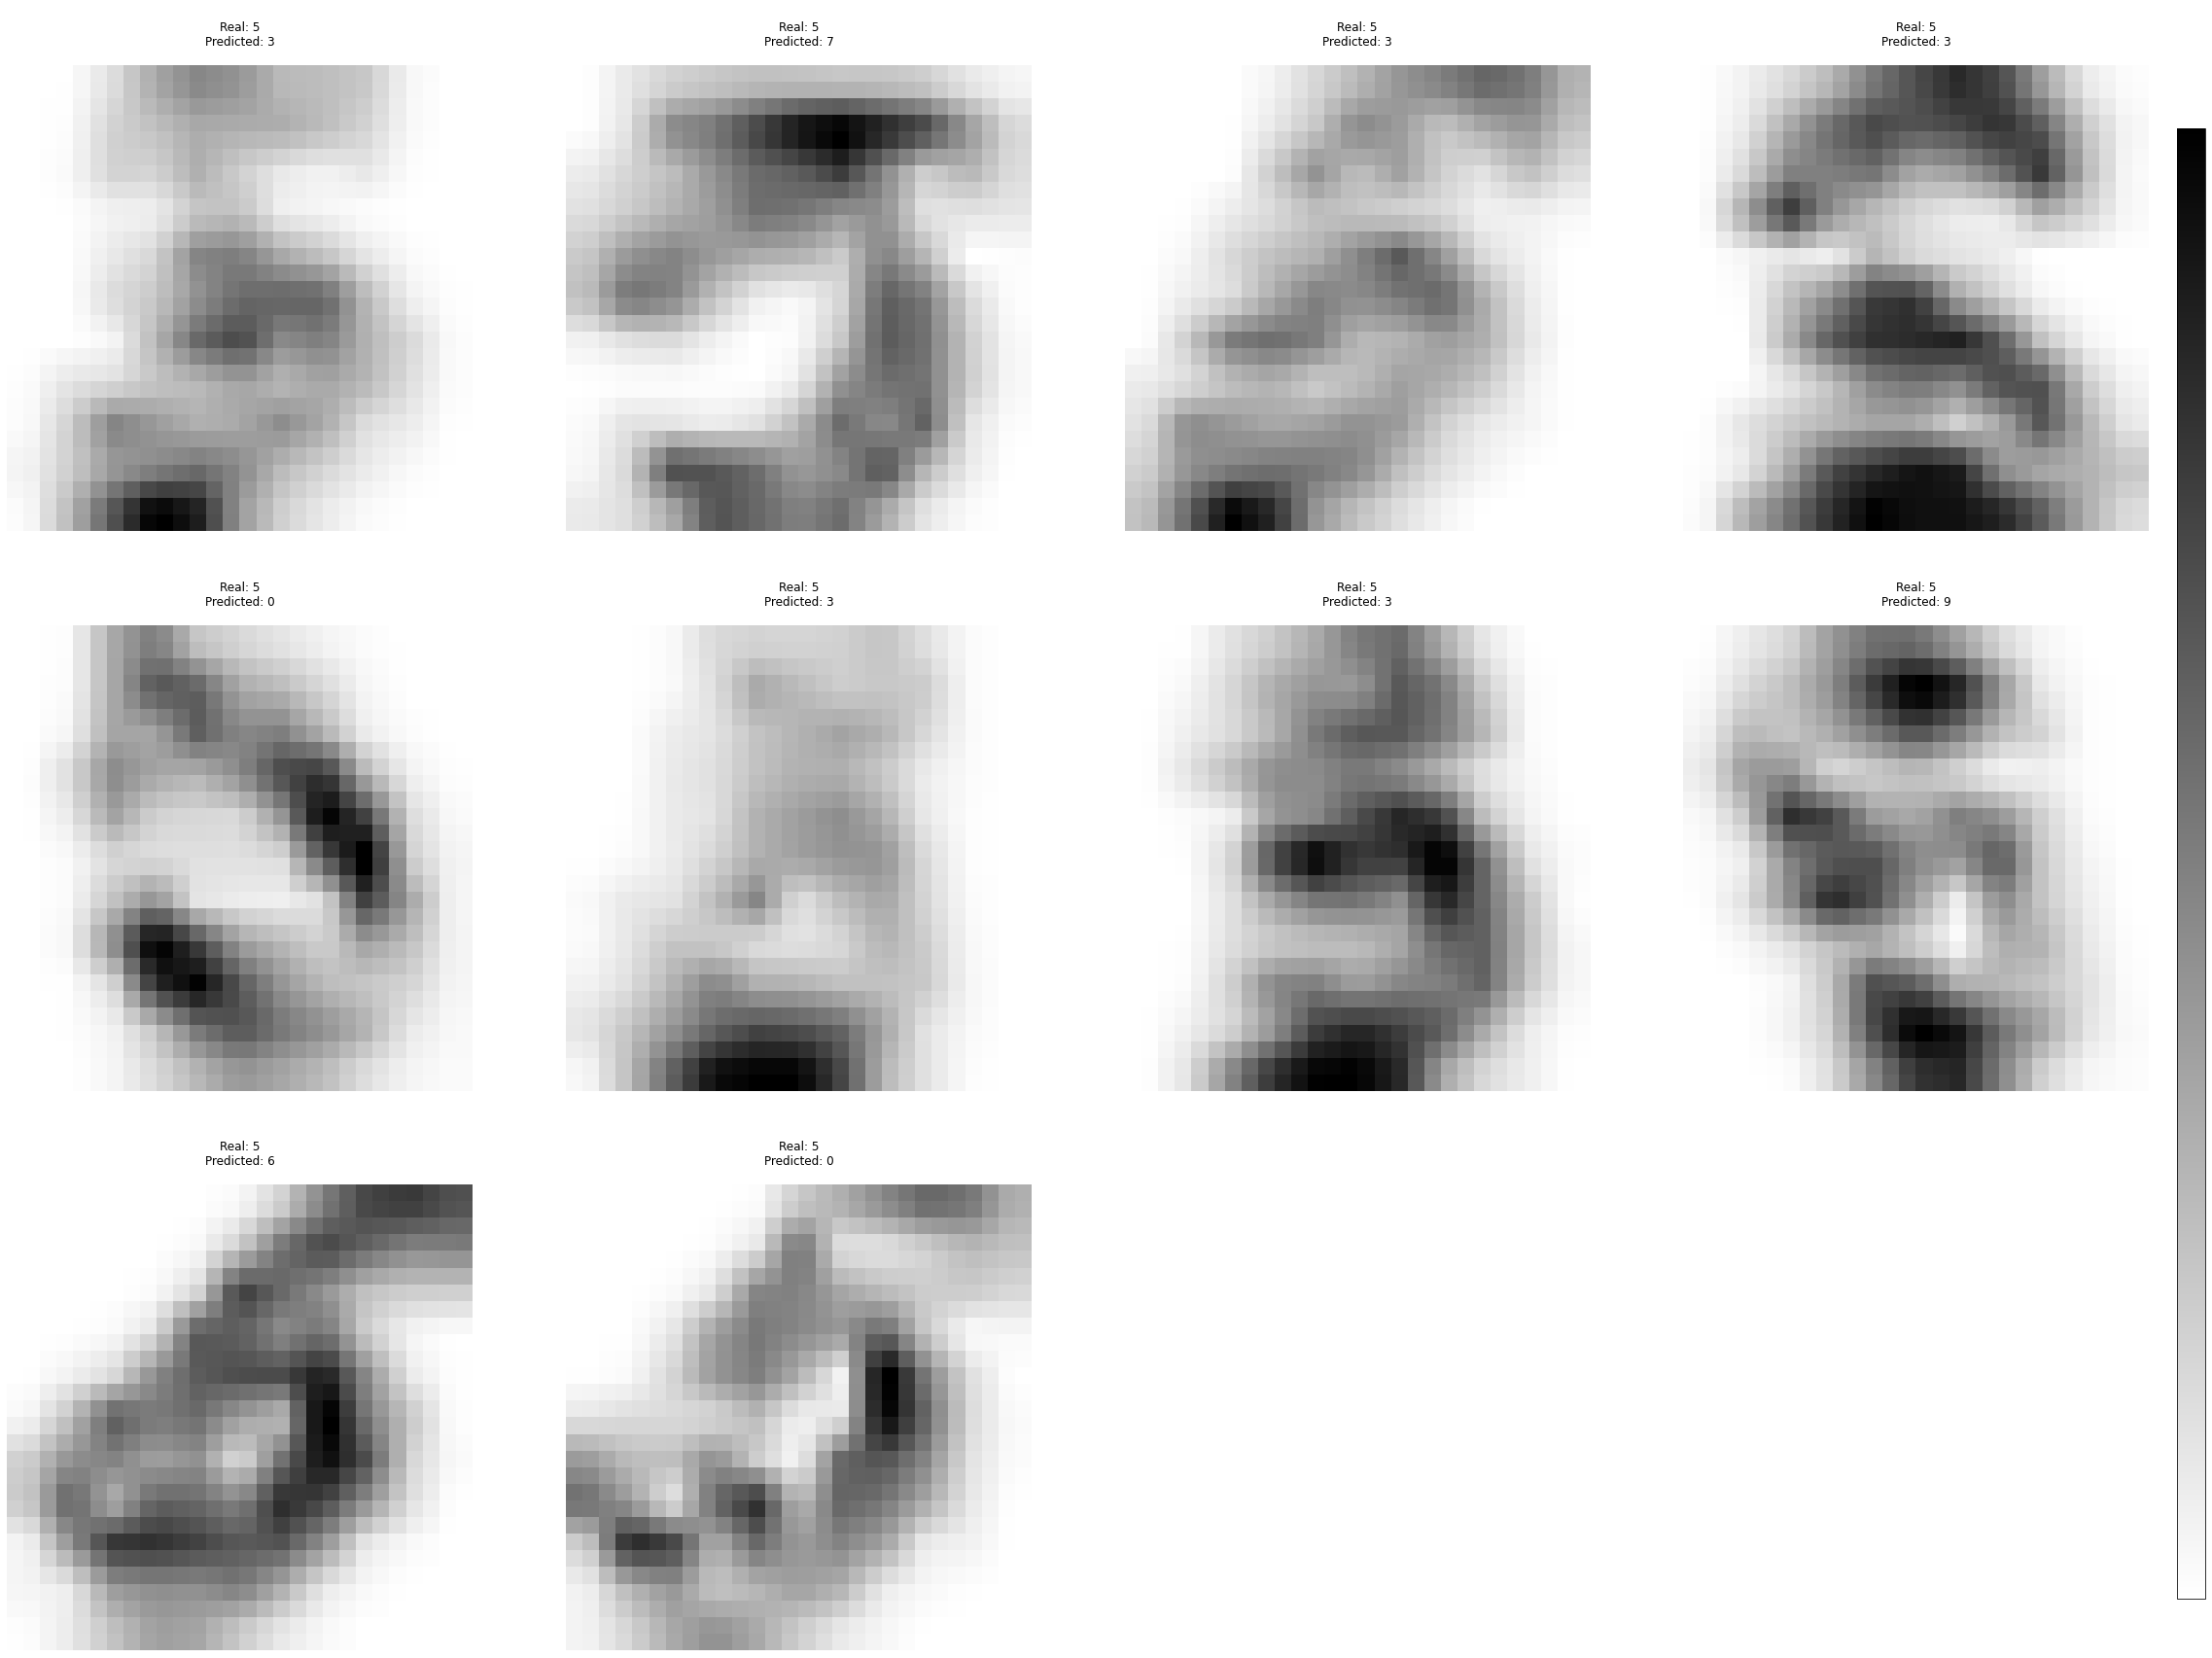

In [139]:
from utils.plotter import contributions_grid

# create the overall figure
fig, ax = contributions_grid(
    contributions=contributions[complete_mask],
    real_labels=test_labels[complete_mask],
    predicted_labels=predictions[complete_mask],
)
fig.show()
save_figure(fig, '../out/gradcampp/contributions_misclassified')

beep()

### Visualize the distribution of the heatmaps

In [140]:
# reduce to 2d using t-SNE
contributions_ld = TSNE(init='pca', learning_rate='auto', perplexity=30, n_iter=300).fit_transform(
    pca_int
)

beep()

/usr/local/Caskroom/miniconda/base/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


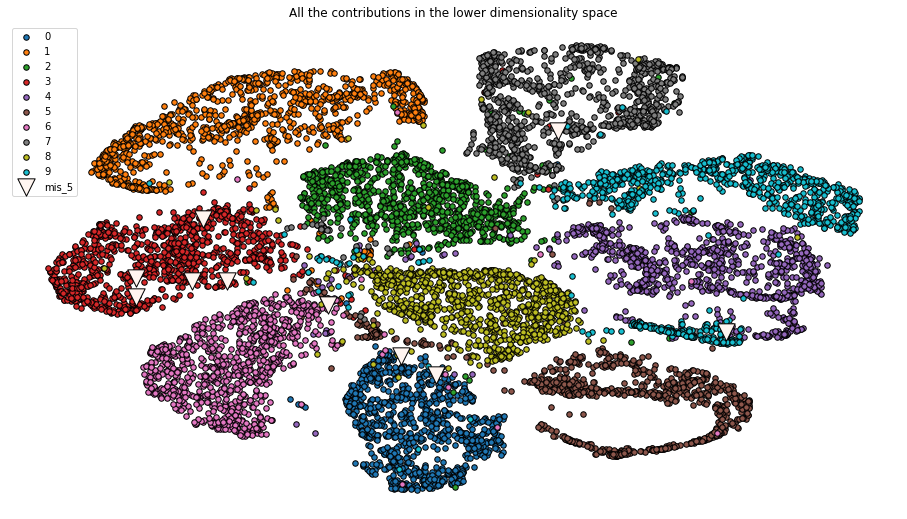

In [141]:
# show all the heatmaps
contributions_fig, contributions_ax = visualize_clusters(contributions_ld, test_labels)
# highlight the misclassified heatmaps
visualize_clusters(
    contributions_ld[complete_mask], test_labels[complete_mask],
    marker='v', size=300, fig=contributions_fig, ax=contributions_ax,
    label_prefix='mis',
    cmap='Reds'
)
contributions_ax.set_title('All the contributions in the lower dimensionality space')
contributions_fig.savefig('../out/contributions_all_latent_space.png', dpi=150, transparent=True)

# Compute the distance matrix

In [142]:
from utils.image_similarity.intensity_based import euclidean_distance
from utils.cluster.preprocessing import distance_matrix

# compute the distance matrix for the contributions
dist_matrix = distance_matrix(contributions[complete_mask], dist_func=euclidean_distance)

### Visualize the distance matrix

In [1]:
from utils.cluster.visualize import visualize_distance_matrix

dist_matrix_fig, dist_matrix_ax = visualize_distance_matrix(
    distance_matrix=dist_matrix,
    heatmaps=contributions[complete_mask]
)
dist_matrix_fig.show()

dist_matrix_fig.savefig('../out/distance_matrix_visual', dpi=150, transparent=False)

beep()

ImportError: cannot import name 'visualize_distance_matrix' from 'utils.cluster.visualize' (/Users/lodovicoazzini/Repos/USI-MSDE/III/Thesis_no_sync/opening-the-black-box_no_sync/utils/cluster/visualize.py)

# Cluster using the distance matrix

### Find the point of maximum curvature for epsilon

The point of maximum curvature is 0.32428110246841546


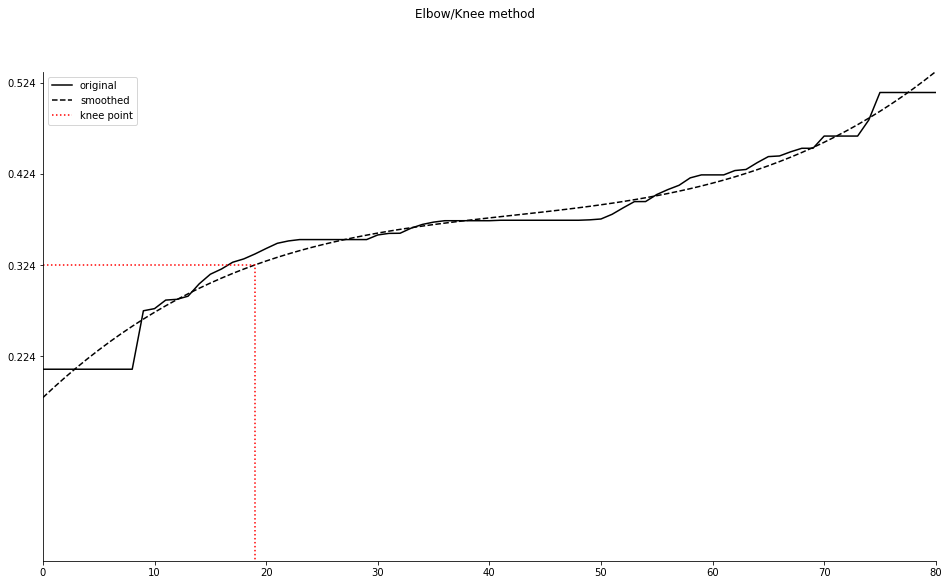

In [144]:
from utils.image_similarity.stats import get_elbow_point

elbow_point, fig, _ = get_elbow_point(dist_matrix, smoothing_factor=.1, plot=True)
print(f'The point of maximum curvature is {elbow_point}')
fig.suptitle('Elbow/Knee method')
fig.savefig('../out/elbow_point.png', dpi=150, transparent=True)

### Compute the clusters

In [150]:

from sklearn.cluster import AffinityPropagation

dm_clusters = AffinityPropagation(affinity='precomputed').fit_predict(dist_matrix)

##### Visualize the clusters

/usr/local/Caskroom/miniconda/base/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


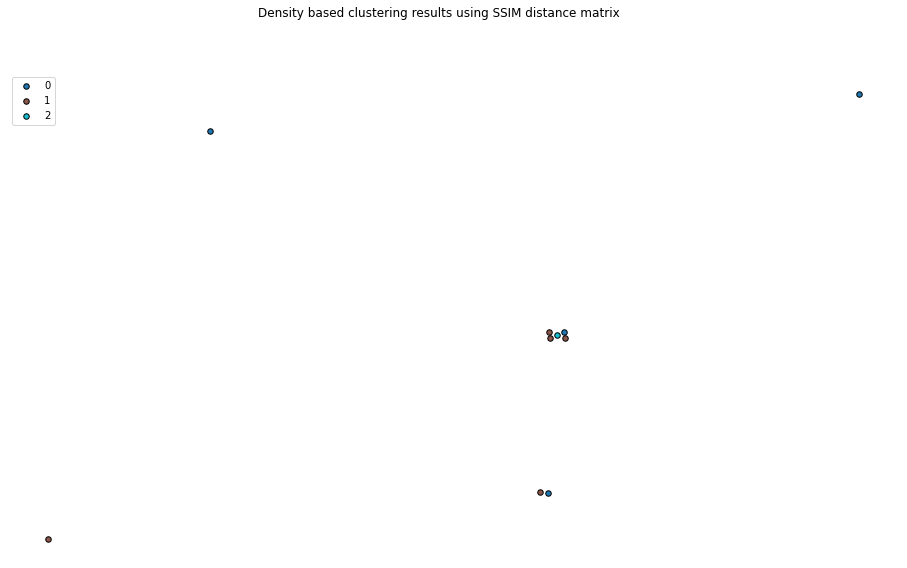

In [146]:
from utils.cluster.visualize import visualize_clusters

fig, ax = visualize_clusters(
    heatmaps=TSNE(perplexity=.1).fit_transform(contributions[complete_mask].reshape(
        contributions[complete_mask].shape[0], -1
    )),
    clusters=dm_clusters
)
fig.suptitle('Density based clustering results using SSIM distance matrix')

fig.savefig('../out/db_clusters_dist_matrx_points', dpi=150, transparent=True)

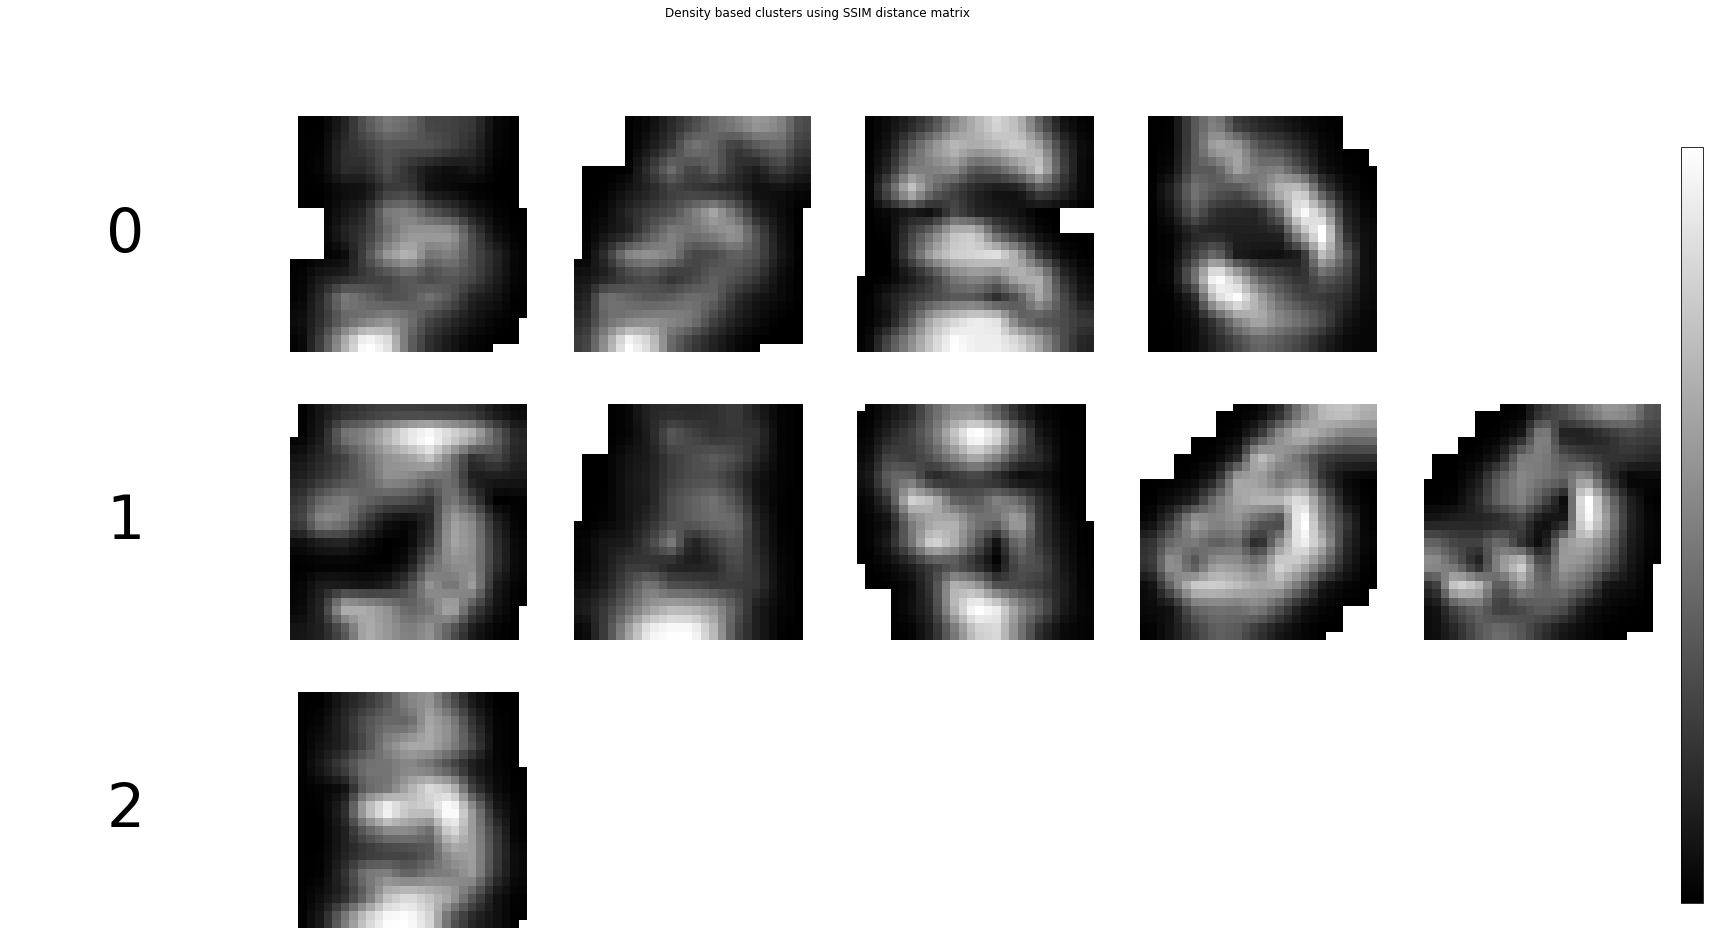

In [147]:
from utils.cluster.visualize import visualize_clusters_images

fig, ax = visualize_clusters_images(clusters=dm_clusters, heatmaps=contributions[complete_mask])
fig.suptitle('Density based clusters using SSIM distance matrix')

fig.savefig('../out/db_clusters_dist_matrx_images', dpi=150, transparent=True)

beep()

# Cluster in the latent space

### CLuster in the complete latent space

In [148]:

from sklearn.metrics import silhouette_score

# optimal = find_optimal_configuration(
#     models=[
#         DBSCAN(metric='euclidean', eps=elbow_point, min_samples=min_samples)
#         for min_samples in range(2, 10)
#     ],
#     data=contributions_ld[complete_mask],
#     verbose=True
# )

lso_clusters = AffinityPropagation().fit_predict(contributions_ld[complete_mask])

# compute the silhouette score for the clusters
print('Silhouette score: ', silhouette_score(
    contributions_ld[complete_mask],
    lso_clusters
))

Silhouette score:  0.46903244


/var/folders/b2/ybzqqdk538s60ppvpsh_9q2m0000gn/T/ipykernel_76849/2398667691.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


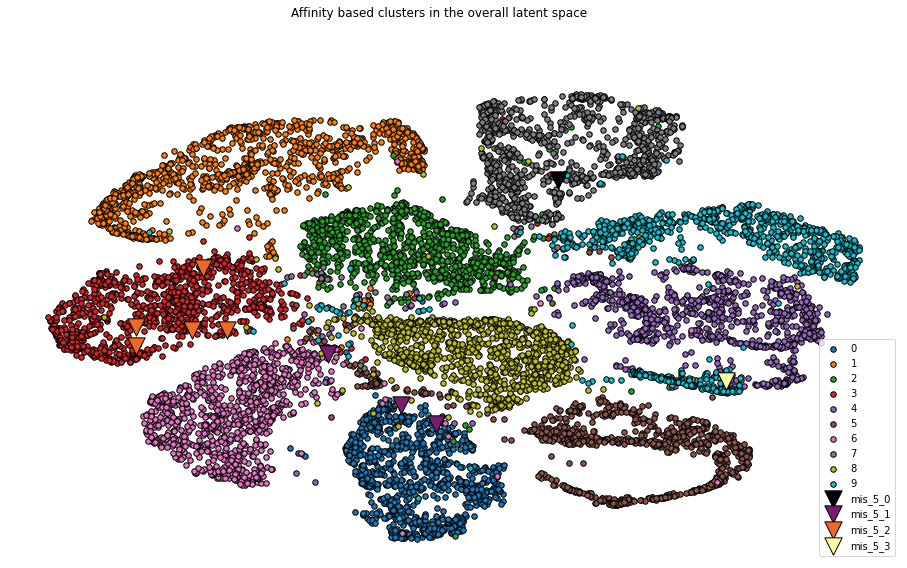

In [151]:
# show all the heatmaps
fig, ax = visualize_clusters(contributions_ld, test_labels)
# highlight the misclassified heatmaps
visualize_clusters(
    contributions_ld[complete_mask], lso_clusters,
    marker='v', size=300, fig=fig, ax=ax,
    label_prefix='mis_5', cmap='inferno'
)
fig.suptitle('Affinity based clusters in the overall latent space')
fig.show()

fig.savefig('../out/affinity_based_overall_latent', dpi=150, transparent=True)

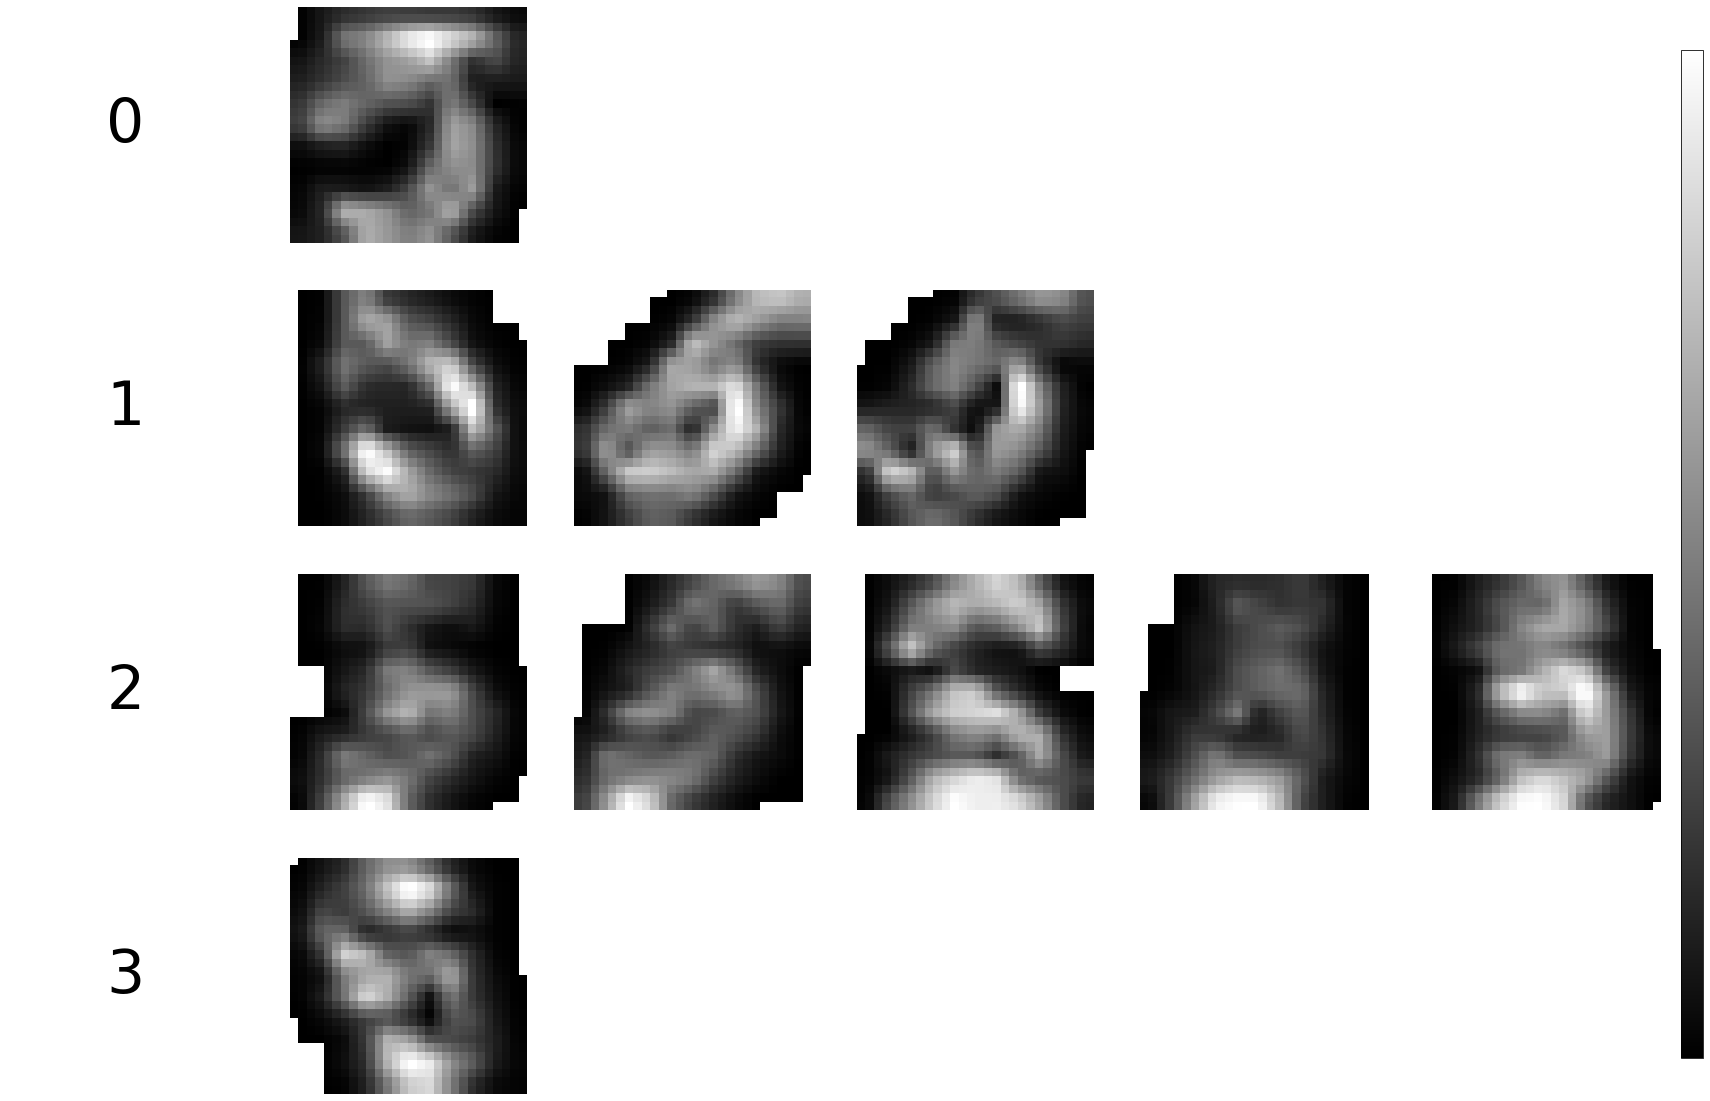

In [152]:
from utils.cluster.visualize import visualize_clusters_images

fig, ax = visualize_clusters_images(clusters=lso_clusters, heatmaps=contributions[complete_mask])

# fig.savefig('../out/db_clusters_dist_matrx_images', dpi=150, transparent=True)

beep()

### Cluster in the selected latent space

In [153]:
# transform the contributions in the latent space
lss_contributions = TSNE(perplexity=.1).fit_transform(contributions[complete_mask].reshape(
    contributions[complete_mask].shape[0],
    -1
))
# cluster the contributions
lss_clusters = AffinityPropagation().fit_predict(lss_contributions)
# compute the silhouette score for the clusters
silhouette_score = silhouette_score(lss_contributions, lss_clusters)
print('Silhouette score: ', silhouette_score)

/usr/local/Caskroom/miniconda/base/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Silhouette score:  0.6390226


/var/folders/b2/ybzqqdk538s60ppvpsh_9q2m0000gn/T/ipykernel_76849/4113870519.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


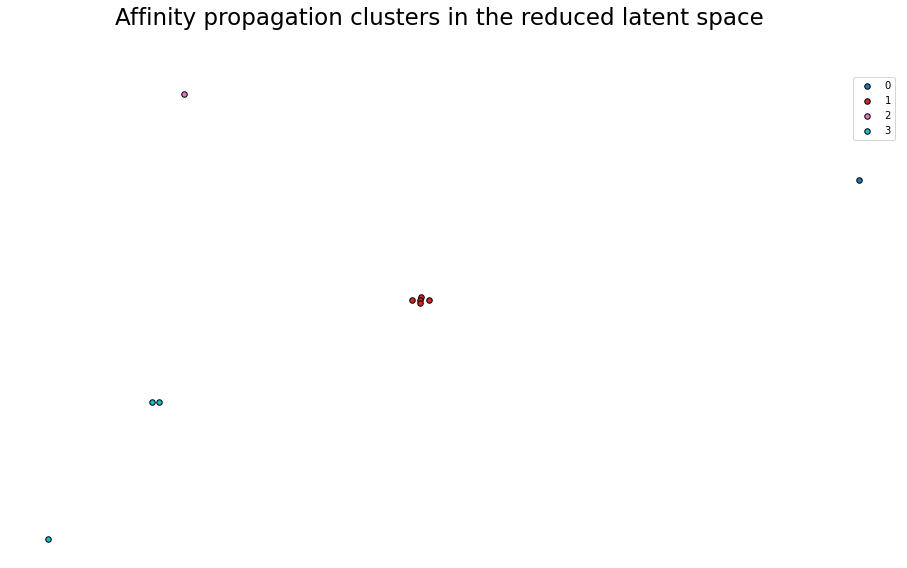

In [154]:
fig, ax = visualize_clusters(
    clusters=lss_clusters, heatmaps=lss_contributions,
)
fig.suptitle('Affinity propagation clusters in the reduced latent space', size=23)
fig.show()

fig.savefig('../out/cluster_points_affinity_propagation_reduced_latent_space')

/var/folders/b2/ybzqqdk538s60ppvpsh_9q2m0000gn/T/ipykernel_76849/540624708.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


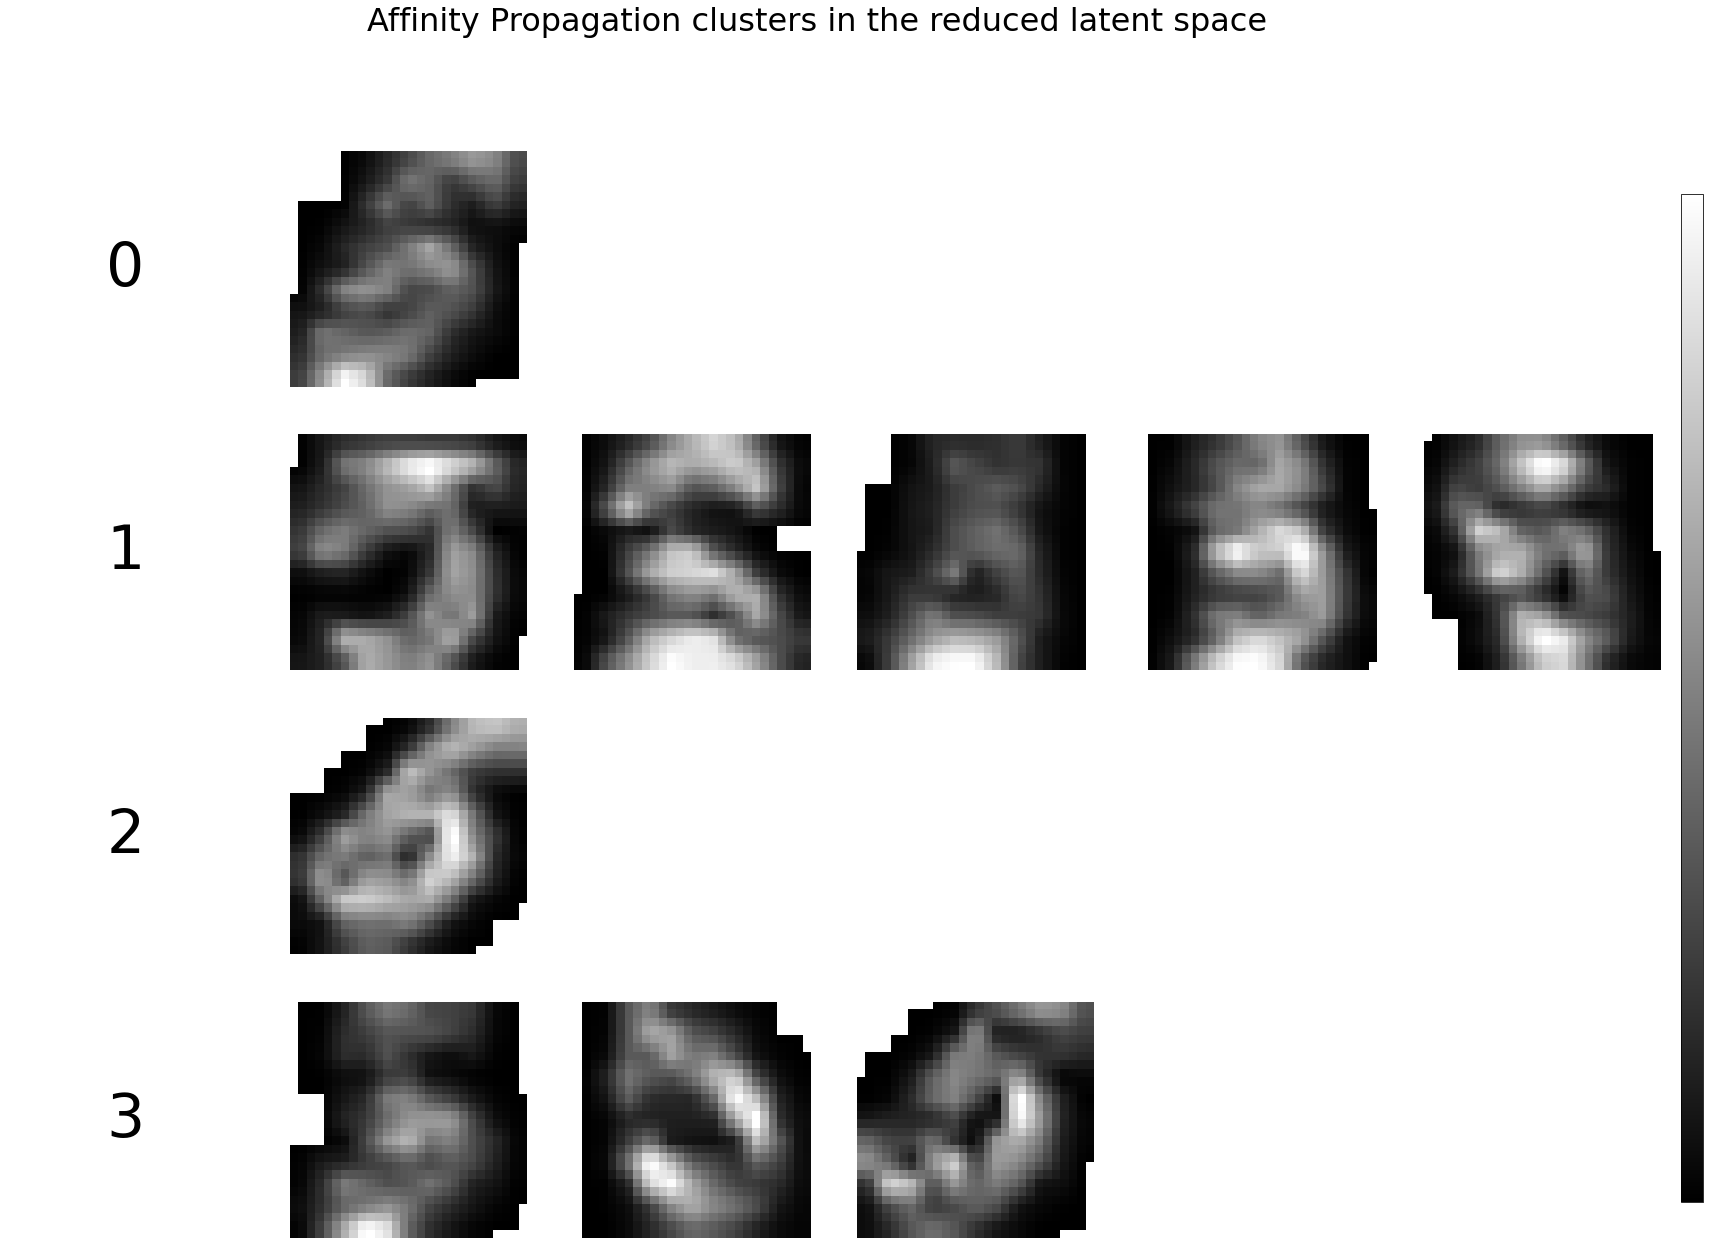

In [155]:
fig, ax = visualize_clusters_images(clusters=lss_clusters, heatmaps=contributions[complete_mask])
fig.suptitle('Affinity Propagation clusters in the reduced latent space', size=32)
fig.show()

fig.savefig('../out/cluster_images_affinity_propagation_reduced_latent_space', dpi=150, transparent=True)

In [197]:
'; '.join([str(label) for label in clusters])

'0; 3; 1; 3; 2; 3; 3; 3; 4; 2'

In [5]:
from sklearn.manifold import TSNE
dim_reducer = TSNE(perplexity=.1)
str(dim_reducer.get_params())

"{'angle': 0.5, 'early_exaggeration': 12.0, 'init': 'warn', 'learning_rate': 'warn', 'method': 'barnes_hut', 'metric': 'euclidean', 'min_grad_norm': 1e-07, 'n_components': 2, 'n_iter': 1000, 'n_iter_without_progress': 300, 'n_jobs': None, 'perplexity': 0.1, 'random_state': None, 'square_distances': 'legacy', 'verbose': 0}"